In [1]:
#NECESSARY PACKAGES! 

#!pip install rich
#!pip install tqdm

In [2]:
import urllib.request 
import urllib.parse

import json
import urllib
import xmltodict

import time
from tqdm.auto import tqdm

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
#Prints a fancy header!
def print_header():
    print("------------------------------------------------------------")
    print("            THE DBPEDIA BOOK LOOKUP TOOL")
    print("------------------------------------------------------------")
    
    
    print("How does this search method work?")
    print("Key word search: Search on key words or incomplete titles. This method is not case-sensitive.")
    print("Title search: Search on complete titles. This method is case-sensitive!")
    
    print("--------------------------------------------------------------------------------")

In [4]:
#Asks the user if he/she wants to perform a title search or a key word search
def keysearch_or_titlesearch():
    print("Type 'key' or 'title'")
    answer = ""
    while answer != "key" and answer != "title":
        answer = input("Key word search or full title search?: ")
        answer = answer.strip()
        answer = answer.lower()
    return answer

In [5]:
#Makes a book input appropriate for a key word/incomplete title search.
def normalizer(book):
    stripped = book.strip()
    lowered = stripped.lower()
    normalized_title = stripped.replace(" ", "%20")
    return(normalized_title)

In [6]:
#Searcher defines the url, launches a urllib request, parses the XML result and turns it into a JSON object.
def searcher(normalized_title):
    url = 'https://lookup.dbpedia.org/api/prefix?query={}&QueryClass=Book'.format(normalized_title)
    response = urllib.request.urlopen(url).read() #response from API
    xml_obj = response #XML response in new variable
    obj = xmltodict.parse(xml_obj) #parse the XML response
    json_obj = json.dumps(obj, ensure_ascii=False) #convert XML response to JSON
    data = json.loads(json_obj) #load the XML response as a JSON object
    return(data)

In [34]:
#list_of_possibilities stores all the books together with their count keys in a global dictionary count_and_title.
#The code was written with the link we originally got. This always returned at least one result. 
#But now I had to add different scenarios:
#code created for the following scenarios:
    #If there is only one book, the result is a nested dictionary.
    #If there are multiple books, the result is a list nested in two dictionaries.
    #If there is no book, the dictionary will be empty.
    
def list_of_possibilities(data): 
    global count_and_title #define a global variable count_and_title
    count_and_title={}
    list_with_results = data['ArrayOfResults']
    if not list_with_results: #If there are no results: set the dictionary to None.
        count_and_title = None
    else: 
        list_with_results = data['ArrayOfResults']['Result'] #go deeper into the json data
        if type(list_with_results) == dict: #If there is only one book result: it is presented as a nested dictionary
            result = data["ArrayOfResults"]["Result"]
            count = 1 #count will be the key in our dictionary
            for k, v in result.items():
                if k == "Label": #The title is always the value of the "Label" key
                    title = v #store title in variable
                    print("[{}]".format(count), title) #print the list of options for the user
                    normalized_title = normalizer(title) #normalize the title
                    count_and_title[count] = title #add key (count) and title to the dictionary
                elif k == "URI":
                    uri = v
    
        else: #If there are multiple book results
            for book in range(len(list_with_results)): #book = length of list_with_results
                result = data["ArrayOfResults"]["Result"][book] #we go deeper into the dic + specify a list object (= one book)
                count = book + 1 #+one, because otherwise it starts at 0 and this is not intuitive for the user
                for k, v in result.items(): #book object is a dictionary in a list. Iterate over book dictionary.
                    if k == "Label": #label is always the title.
                        title = v
                        print("[{}]".format(count), title) #print the title. Same as above.
                        normalized_title = normalizer(title) #normalize title.
                        count_and_title[count] = title #add to dictionary.
                    elif k == "URI":
                        uri = v

In [8]:
def user_input():
    checker=0
    while checker==0: #if the book input is not good, the while will continue ENDLESSLY until it's correct!
        book = input("What book title are you after? Enter (part of) a title  or a keyword: ") #ask for a key word/part of a title
        normalized_title = normalizer(book) #normalize the title
        list_with_results = searcher(normalized_title) #turn fetched XML object into a JSON object and store in variable 
        list_of_possibilities(list_with_results) #look in the dictionary count_and_title defined in list_of_possibilities()
        if not count_and_title: #if the dictionary is empty, the book is not there. I only got this problem with the new link.
            print("This book was not found!") #print that the book is not there and continue
            continue
        print("Type yes | no !") #if the book is there:    
        in_options = input("Is the book you're looking for in this list?: ") #is the book in the list? Yes/no
        answer = normalizer(in_options) #normalize the input
        if answer == "yes": #if the answer = yes, break the loop and return book
            checker=1
        elif answer == "no": #if the answer = no, loading bar + back to main page
            print("Let me take you back!")
            for num in tqdm(range(100), desc= "Going back to main page..."):
                time.sleep(0.01)
    return(book)

In [9]:
#A function to make the title approrpiate for the http://dbpedia.org/data/{}.json link,
#by stripping and replacing spaces with an underscore.
def capitalizer(title):
    stripped = title.strip()
    underscored = stripped.replace(" ","_")
    return(underscored)

In [10]:
#The user gets a list of book titles and a number. 
#The user gets to pick one for which (s)he wants more information.
def choice_in_dictionary(count_and_title):
    choice = input("Enter the number of the book you're looking for: ") 
    while choice not in ["1","2","3","4","5","6","7","8","9","10"]: #Maximally 10 hits are returned.
        print("uh-oh, that was not a correct input!") 
        choice = input("Enter the number of the book you're looking for: ")
    choice = int(choice) #input is always str. Change to integer to search the dictionary.
    if choice in count_and_title.keys():
        json_title = count_and_title.get(choice) #json title = the title of your choice
        json_title = capitalizer(json_title)
        new_url = "http://dbpedia.org/data/{}.json".format(json_title)
        return new_url, json_title #new url in .json format, and the title made appropriate for the JSON-link
    return None, None #if empty: return none for both

In [11]:
def title_search(): #if the user wants to search based on a title. Then this becomes new_url, json_title
    book_title = input("Enter the complete title of the book: ") #this is case-sensitive!
    book_title = capitalizer(book_title) #strip and underscore
    title_url = "http://dbpedia.org/data/{}.json".format(book_title) #json_title
    return title_url, book_title

In [12]:
def get_json_response(new_url, json_title): #return json_results for that particular book
    json_response = urllib.request.urlopen(new_url) 
    json_data = json.loads(json_response.read()) #read in JSON data for "http://dbpedia.org/data/{}.json"
    
    for k,v in json_data.items():
        if k == "http://dbpedia.org/resource/{}".format(json_title):
            json_results = v #list of json results for that particular book
            return(json_results)
    return(None)

In [13]:
#We use the json url to fetch information: abstract.
#We iterate over the dictionaries and lists until we reach "http://dbpedia.org/ontology/abstract."
#we only take the ENGLISH abstract and ignore translations.
#We store the abstract in a variable.
#If the abstract is not there, return a string error message. This works because abstract would also be of type string.

def get_abstract(json_results): 
    for key, value in json_results.items():
        if key == "http://dbpedia.org/ontology/abstract":
            for language in value:
                for keys, values in language.items():
                    if values == "en":
                        English_element = language #access only the English element out of the json results
                        for k, v in English_element.items():
                            if k == "value":
                                abstract = v
    error_message = "Abstract was not available!"
    return(error_message)

In [14]:
def unlink(link): #Remove the link bit to print stuff nicely in string format
    remove = "http://dbpedia.org/resource/"
    needed = link.replace(remove, "")
    needed = needed.replace("_", " ")
    return(needed)

In [15]:
#We use the json url to fetch information: literary genre

def get_literary_genre(json_results):
    for key, value in json_results.items():
        if key =="http://dbpedia.org/ontology/literaryGenre":
            for genre in value:
                for keys, values in genre.items():
                    if keys == "value":
                        genre_link = values
                        genre_str = unlink(genre_link)
                        return(genre_str)
    error_message = "Literary genre was not available!"
    return(error_message)

In [16]:
#Use the JSON url to fetch information: author name

def get_author(json_results):
    for key, value in json_results.items():
        if key =="http://dbpedia.org/ontology/author":
            for author in value:
                for keys, values in author.items():
                    if keys =="value":
                        author_link = values
                        author_str = unlink(author_link)
                        return(author_str)
    error_message = "Author was not available!"
    return(error_message)

In [17]:
#Use JSON url to fetch information: publication date
def get_date_published(json_results):
    for key, value in json_results.items():
        if key == "http://dbpedia.org/ontology/publicationDate":
            for date in value:
                for keys, values in date.items():
                    if keys == "value":
                        date_published = values
                        return(date_published)
    error_message = "Publication date was not available!"
    return(error_message)

In [18]:
#Fetch the ISBN.
#This will also be used to fetch images with the Open Library API! 
#Sadly, with the new link, there are very few ISBNs available. It used to work really well. :(
def get_isbn(json_results):
    for key, value in json_results.items():
        if key == "http://dbpedia.org/ontology/isbn":
            for isbn in value:
                for keys, values in isbn.items():
                    if keys =="value":
                        isbn_str = values
                        return(isbn_str)
    error_message = "ISBN was not available!"
    return(error_message)

In [19]:
def make_link_appropriate(name):
    linked = name.replace(" ", "_")
    return(linked)

In [20]:
#Fetch metadata: get more information on the author by putting the Author name into a new url. Fetch info from url.
def get_more_info_author(author_name):
    author_name = make_link_appropriate(author_name)
    author_url = "http://dbpedia.org/data/{}.json".format(author_name)
    author_json_results = get_json_response(author_url, author_name)
    if author_json_results == None: #if author is not available, just return None.
        return(None)
    else: 
        return(author_json_results)

In [21]:
#Get a little abstract about the author. If not available: error message.
def get_author_abstract(author_json_results):
    for k, v in author_json_results.items(): #get abstract 
        if k == "http://dbpedia.org/ontology/abstract":
            for abstracts in v:
                for k, v in abstracts.items():
                    if v == "en":
                        English_abstract = abstracts
                        for k, v in English_abstract.items():
                            if k == "value":
                                author_abstract = v
                                return(author_abstract)
    error_message = "Author abstract was not available!"
    return(error_message)

In [22]:
#Get the birth name of the author if available. If not: error message.
def get_author_birthname(author_json_results):
    for k, v in author_json_results.items(): #get birth name
        if k == "http://dbpedia.org/ontology/birthName":
            for name in v:
                for k, v in name.items():
                    if k == "value":
                        birthname = v
                        return(birthname)
    error_message = "Author birthname was not available!"
    return(error_message)
    

In [23]:
#Get the birth date of the author if available. If not: error message.
def get_author_birth_date(author_json_results):
    for k,v in author_json_results.items(): #get birth date 
        if k == "http://dbpedia.org/ontology/birthDate":
            for date in v:
                for k, v in date.items():
                    if k == "value":
                        birthdate = v 
                        return(birthdate)
    error_message = "Author birth date was not available!"
    return(error_message)

In [24]:
#Normalize the ISBN to fetch an image from the Open Library API. Make it link-appropriate.
#As mentioned above, there are very few ISBNs available with the new link, which is very sad because it worked so well before.
def isbn_normalizer(isbn):
    isbn = isbn.replace("-", "")
    return(isbn)

In [25]:
#Fetch the image, make it Jupyter Notebook-readable.
def get_image(isbn):
    isbn = isbn_normalizer(isbn)
    image_url = "http://covers.openlibrary.org/b/isbn/{}-M.jpg".format(isbn)
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return img

In [28]:
#Print all the information in a pretty way with the rich package!
def pretty_print_all_results(title, abstract, genre, author, date_published, isbn, author_abstract, birth_name, birth_date, image): #also add title
    print(" ")
    print("Book Info")
    print("-----------")
    imgplot = plt.imshow(image)
    plt.axis("off")
    plt.show()
    print("Title: {}".format(unlink(json_title)))
    print("Book summary: {}".format(abstract))
    print("Literary genre: {}".format(genre))
    print("Date Published:{}".format(date_published))
    print("ISBN code:{}".format(isbn))
    
    print(" ")
    print(" Author Info ")
    print("--------------------")
    
    print("Author name: {}".format(author)) #print auteur als laatste zodat je nog extra info kan printen
    print("Author info: {}".format(author_abstract))
    print("Birth name: {}".format(birth_name))
    print("Birth date: {}".format(birth_date))

------------------------------------------------------------
            THE DBPEDIA BOOK LOOKUP TOOL
------------------------------------------------------------
How does this search method work?
Key word search: Search on key words or incomplete titles. This method is not case-sensitive.
Title search: Search on complete titles. This method is case-sensitive!
--------------------------------------------------------------------------------
Type 'key' or 'title'
Key word search or full title search?: KEY
What book title are you after? Enter (part of) a title  or a keyword: asshole
[1] Asshole: How I Got Rich and Happy by Not Giving a Shit About You
[2] Assholes Finish First
[3] Assholes: A Theory
Type yes | no !
Is the book you're looking for in this list?: yes
Enter the number of the book you're looking for: 1
 
Book Info
-----------


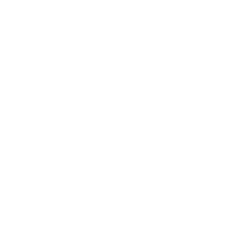

Title: Asshole: How I Got Rich and Happy by Not Giving a Shit About You
Book summary: Abstract was not available!
Literary genre: Literary genre was not available!
Date Published:Publication date was not available!
ISBN code:0-14-103105-0
 
 Author Info 
--------------------
Author name: Martin Kihn
Author info: Martin Kihn is an American writer and digital marketer.
Birth name: Martin Theodore Kihn
Birth date: Author birth date was not available!
Another book? Type yes | noyes
Next round!
Type 'key' or 'title'
Key word search or full title search?: key
What book title are you after? Enter (part of) a title  or a keyword: on the origin of species
[1] On the Origin of Species
Type yes | no !
Is the book you're looking for in this list?: yes
Enter the number of the book you're looking for: 1
 
Book Info
-----------


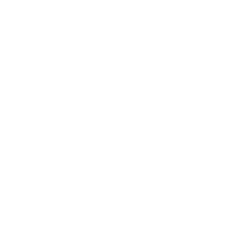

Title: On the Origin of Species
Book summary: Abstract was not available!
Literary genre: Biology
Date Published:Publication date was not available!
ISBN code:ISBN was not available!
 
 Author Info 
--------------------
Author name: Charles Darwin
Author info: Charles Robert Darwin, FRS FRGS FLS FZS (/ˈdɑːrwɪn/; 12 February 1809 – 19 April 1882) was an English naturalist and geologist, best known for his contributions to the science of evolution. He established that all species of life have descended over time from common ancestors, and in a joint publication with Alfred Russel Wallace introduced his scientific theory that this branching pattern of evolution resulted from a process that he called natural selection, in which the struggle for existence has a similar effect to the artificial selection involved in selective breeding. Darwin published his theory of evolution with compelling evidence in his 1859 book On the Origin of Species, overcoming scientific rejection of earlier concep

In [35]:
""" Main code gives the user two options:
1) Key word/incomplete title search
2) Rigid case-sensitive title search

for scenario 1:
> app returns a list of options and lets the user choose from the list

for scenario 2:
> you immediately get the result if you type in a correct title.


For both scenarios, we eventually get:

Book data and metadata:
> book title

> a book cover if available. (Open Library Covers)
>>>>> NOTE: as mentioned prior: ISBNs used to be almost always available with the old link we got.
            Sadly, the new link rarely returns ISBNs. The function still works for books which have an ISBN number.
            If you want to test this function, look for e.g.:
                      - Harry Potter and the Deathly Hallows
                      - Wonderland (novella). 
                      - Alice,  I think (novel)
                      -...
            It used to work very well with the old link. :(

> book abstract
> literary genre
> isbn

Author metadata:
> author name
> author info
> birth name
> birth date

It initiates the while loop until it is broken by the user if he/she doesn't want to look for a book anymore.

"""

print_header()
doorgaan=1
while doorgaan==1:
    answer = keysearch_or_titlesearch()
    if answer == "title":  
        new_url, json_title = title_search()
        if new_url ==None or json_title ==None:
            print("There was no info available for this book!")
            continue
        json_results = get_json_response(new_url, json_title)
        if json_results == None:
            print("There was no info available for this book!")
            continue
        abstract = get_abstract(json_results)
        genre = get_literary_genre(json_results)
        author = get_author(json_results)
        date_published = get_date_published(json_results)
        isbn = get_isbn(json_results)
        author_json_results = get_more_info_author(author)
        if author_json_results == None:
            print("There was no info available for this book!")
            continue
        author_abstract = get_author_abstract(author_json_results)
        birth_name = get_author_birthname(author_json_results)
        birth_date = get_author_birth_date(author_json_results)
        image= get_image(isbn)

        pretty_print_all_results(json_title, abstract, genre, author, date_published, isbn, author_abstract, birth_name, birth_date,  image)
        
        vraag = ""
        while vraag not in ["yes", "no"]: #keep asking until user says yes or no
            vraag=input("Another book? Type yes | no") #ask user if he/she wants to look for another book
            if vraag=="no": #print goodbye message
                time.sleep(0.5)
                print("Goodbye!")
                print("Thank you for using our DBPEDIA book lookup tool!")
                doorgaan=0
            elif vraag=="yes":
                print("Next round!")


    elif answer == "key":
        book = user_input()
        new_url, json_title = choice_in_dictionary(count_and_title)
        if new_url ==None or json_title ==None:
            print("There was no info available for this book!")
            continue
        json_results = get_json_response(new_url, json_title)
        if json_results == None:
            print("There was no info available for this book!")
            continue
        abstract = get_abstract(json_results)
        genre = get_literary_genre(json_results)
        author = get_author(json_results)
        date_published = get_date_published(json_results)
        isbn = get_isbn(json_results)

        author_json_results = get_more_info_author(author)
        if author_json_results == None:
            print("There was no info available for this book!")
            continue
        author_abstract = get_author_abstract(author_json_results)
        birth_name = get_author_birthname(author_json_results)
        birth_date = get_author_birth_date(author_json_results)
        image = get_image(isbn)

        pretty_print_all_results(json_title, abstract, genre, author, date_published, isbn, author_abstract, birth_name, birth_date, image)
        
        vraag = ""
        while vraag not in ["yes", "no"]:
            vraag=input("Another book? Type yes | no")
            if vraag=="no":
                time.sleep(0.5)
                print("Goodbye!")
                print("Thank you for using our DBPEDIA book lookup tool!")
                doorgaan=0
            elif vraag=="yes":
                print("Next round!")